<a href="https://colab.research.google.com/github/Mrtastic26/pembelajaran-mesin_Rehan-Khairuno_2211533003/blob/main/Pekan_2_Logistic_Regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing basic modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading data
health_data = pd.read_csv("healthcare-dataset-stroke-data.csv")


In [3]:
# viewing shape
print('Number of rows are {} | Number of column are {}'\
.format(health_data.shape[0], health_data.shape[1]))

Number of rows are 5110 | Number of column are 12


In [4]:
# checking the column data types
health_data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [6]:
# Checking the unique values of a few numeric columns
# to check if their variable type is numerical or categorical
for i in ['hypertension', 'heart_disease', 'stroke']:
    print('Unique values in {} are : {}'.format(i, health_data[i].unique().tolist()))


Unique values in hypertension are : [0, 1]
Unique values in heart_disease are : [1, 0]
Unique values in stroke are : [1, 0]


In [7]:
# creating summary statistics using describe()
desc_stats = health_data.describe().T

In [10]:
# Assuming desc_stats is already defined and contains 'std' and 'mean'
desc_stats['coeff_of_var'] = desc_stats['std'] / desc_stats['mean']



In [11]:
# dropping id variable
df = health_data.drop('id', axis=1)

In [12]:
# checking for missing values
df.isna().sum()[df.isna().sum()>0]

bmi    201
dtype: int64

In [13]:
# performing median value imputation
df['bmi'] = df.bmi.fillna(df.bmi.median())

In [14]:
# re-checking for missing values
df.isna().sum().sum()

0

<Axes: >

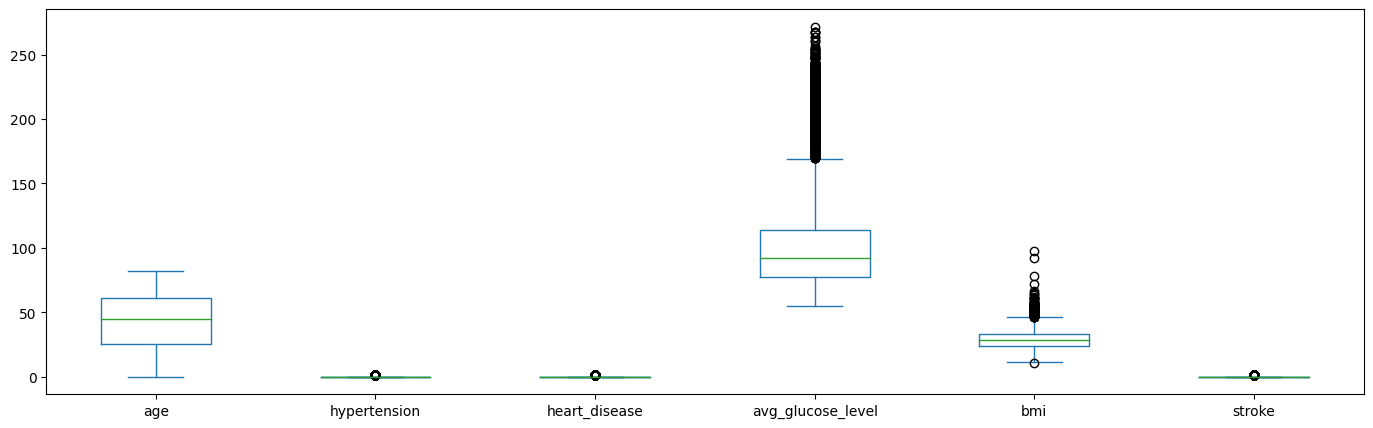

In [15]:
# checking for outliers
df.plot(kind = 'box', figsize=(17, 5))

In [16]:
# removing major outliers from avg_glucose_level
p90_avg_glucose_level = df.avg_glucose_level.quantile(0.90)
df.avg_glucose_level.clip(upper = p90_avg_glucose_level, inplace=True)

In [17]:
# removing major outliers from bmi
p99_bmi = df.bmi.quantile(0.99)
df.bmi.clip(upper = p99_bmi, inplace=True)

<Axes: >

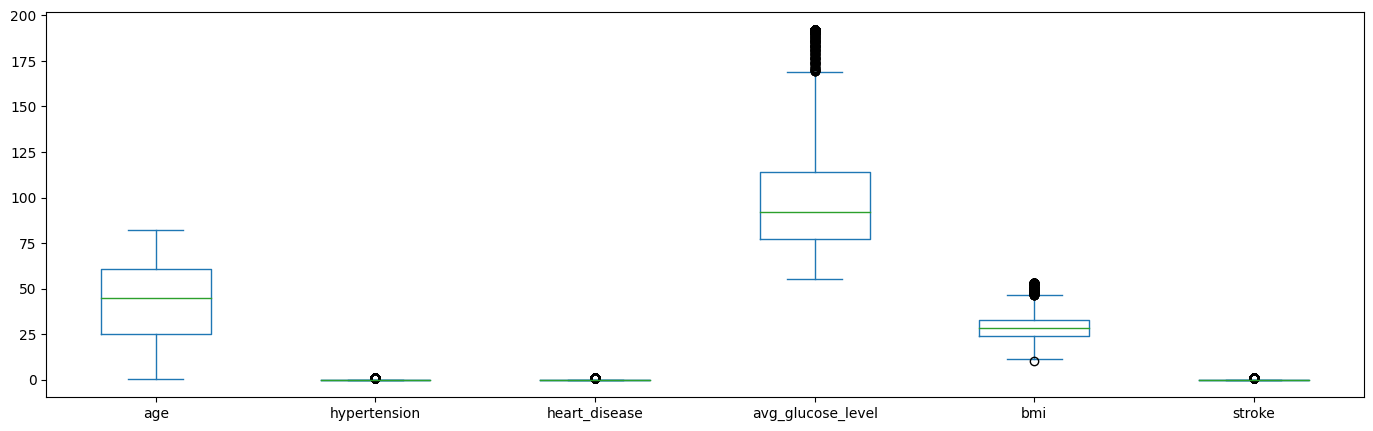

In [18]:
# ensuring that any major outliers are not there
df.plot(kind = 'box', figsize=(17, 5))



In [19]:
# extracting the numeric data type columns in separate dataframe
num_dtype_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_num = df[num_dtype_cols]

In [20]:
# extracting the object data type columns in separate dataframe
object_dtype_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
df_obj = df[object_dtype_cols]

In [21]:
# displaying data only having the 'object' data type columns
df_obj

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked
5106,Female,Yes,Self-employed,Urban,never smoked
5107,Female,Yes,Self-employed,Rural,never smoked
5108,Male,Yes,Private,Rural,formerly smoked


In [22]:
# label encoding all columns with data type 'object'
from sklearn.preprocessing import LabelEncoder
df_obj = df_obj.apply(LabelEncoder().fit_transform)

In [23]:
# combining all the numeric and object data type columns
df = pd.concat([df_obj, df_num], axis=1)

In [24]:
# ensuring that all data types are numeric
df.dtypes

gender                 int64
ever_married           int64
work_type              int64
Residence_type         int64
smoking_status         int64
age                  float64
hypertension           int64
heart_disease          int64
avg_glucose_level    float64
bmi                  float64
stroke                 int64
dtype: object

In [25]:
# calculating feature importance
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [26]:
# splitting data in train and test
training_features, _, training_labels, _, = train_test_split(
df.drop('stroke', axis=1),
df.stroke, test_size = 0.3,
random_state = 123
)

In [27]:
# scaling data
scaler = StandardScaler()
training_features_scaled = scaler.fit_transform(training_features)

In [28]:
# fitting a tree basec classifier - XGBoost
XGBC_model = XGBClassifier()
XGBC_model.fit(training_features_scaled, training_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
# saving the importance score with the column names in a dataframe
importance_df = pd.DataFrame(
data={'feature': training_features.columns,
'importance': XGBC_model.feature_importances_})

In [30]:
# sorting the importance score in descending order
feature_importances = pd.Series(XGBC_model.feature_importances_,
index = training_features.columns)\
.sort_values(ascending = False)

<Axes: >

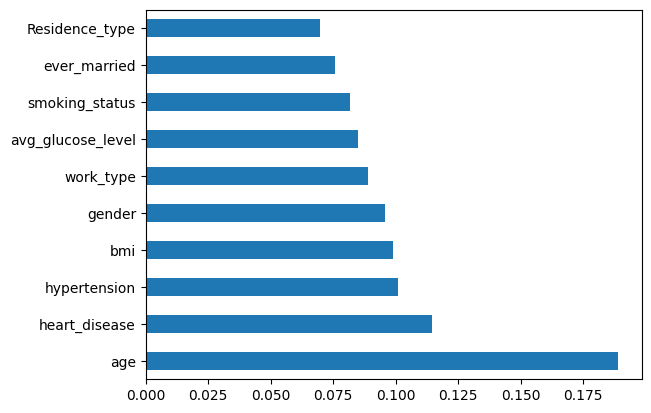

In [31]:
# plotting the importance
feature_importances.plot(kind = 'barh')

In [32]:
# extracting the important columns (along with the dependent variable) from the clean data
imp_cols_6 = feature_importances.iloc[0:6].index.tolist()
df = df[imp_cols_6+['stroke']]

<Axes: >

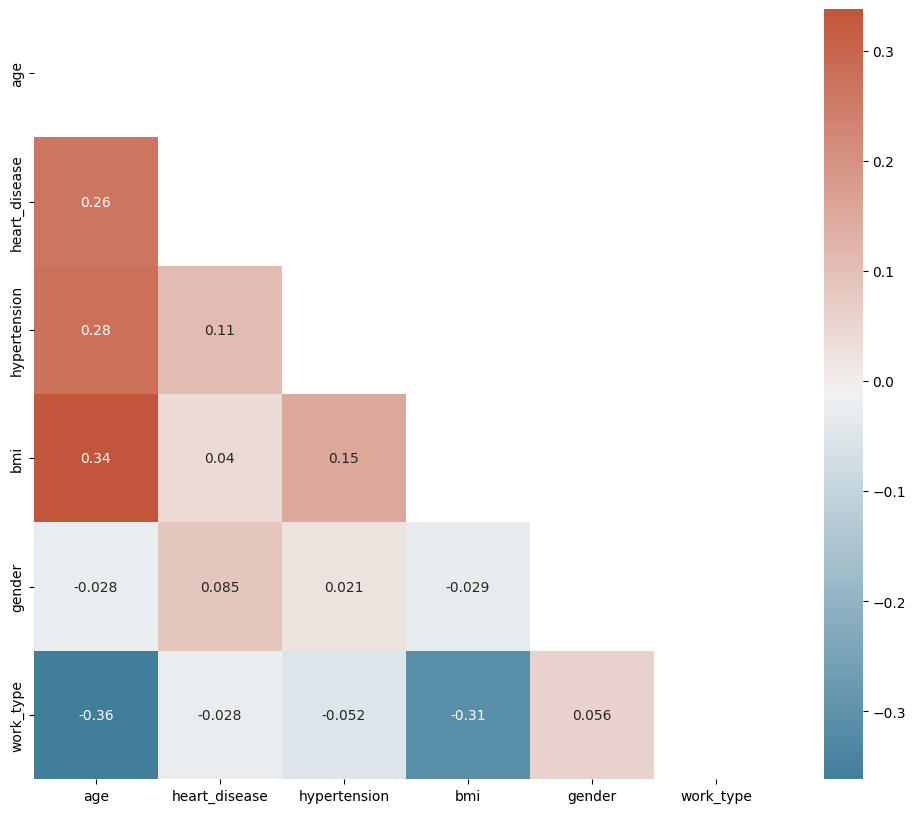

In [33]:
# checking for correlation among variables
import seaborn as sns
corr = df.drop('stroke',axis=1).corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [34]:
# calculating VIF score for each variable
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# saving all the independent features
features = df.drop('stroke', axis=1)

# calculating vif score for each feature
vif_scores = pd.Series(
[vif(features.values, i) for i in range(len(features.columns))] )

# adding column names to the vif score
vif_scores.index = features.columns

# sorting the vif scores in descending order
vif_scores = vif_scores.sort_values(ascending=False)
vif_scores

bmi              8.498494
age              5.842116
work_type        3.390381
gender           1.688256
hypertension     1.194052
heart_disease    1.150324
dtype: float64

In [35]:
# removing the column with the second highest VIF score as the column

# with the highest VIF score is highly important
features.drop('bmi', axis=1, inplace=True)

In [36]:
# recalculating VIF score
vif_scores = pd.Series([vif(features.values, i) for i in range(len(features.columns))])
vif_scores.index = features.columns
vif_scores.sort_values(ascending=False)
vif_scores

age              2.536401
heart_disease    1.128456
hypertension     1.193651
gender           1.646189
work_type        2.328032
dtype: float64

In [37]:
# dropping 'bmi' column from the main data
df.drop('bmi', axis=1, inplace=True)

In [38]:
# saving all the columns to be used for modeling
final_columns = df.columns
final_columns

Index(['age', 'heart_disease', 'hypertension', 'gender', 'work_type',
       'stroke'],
      dtype='object')

In [39]:
# splitting the data into train and test
train_data, test_data = train_test_split(df, test_size=0.3, random_state=123)

In [42]:
# fitting logistic regression model using statsmodels
from statsmodels.formula import api as smf



In [45]:
import pandas as pd
import statsmodels.formula.api as smf

# Assuming train_data is your DataFrame containing training data
# Add 'ever_married' column if it's missing
if 'ever_married' not in train_data.columns:
    # Add logic to populate 'ever_married' based on other columns or data source
    train_data['ever_married'] = ...

# Verify 'ever_married' is now in train_data.columns
print(train_data.columns)

# Fit the model
model_sm = smf.logit('stroke ~ age + ever_married + heart_disease + hypertension', data=train_data).fit()

# Print summary
print(model_sm.summary2())


Index(['age', 'heart_disease', 'hypertension', 'gender', 'work_type', 'stroke',
       'ever_married'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.158994
         Iterations 9
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: stroke           Pseudo R-squared: 0.206     
Date:               2024-06-14 08:15 AIC:              1145.4464 
No. Observations:   3577             BIC:              1170.1756 
Df Model:           3                Log-Likelihood:   -568.72   
Df Residuals:       3573             LL-Null:          -716.41   
Converged:          1.0000           LLR p-value:      1.0017e-63
No. Iterations:     9.0000           Scale:            1.0000    
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Interc

In [50]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Assuming model_sm is already fitted
# Compute odds ratios and confidence intervals
odds_ratios = np.exp(model_sm.params)
conf_int = np.exp(model_sm.conf_int())
z_values = model_sm.tvalues
p_values = model_sm.pvalues
beta_coeffs = model_sm.params

# Create a DataFrame for interpretation
coeff_interpret = pd.DataFrame({
    'log_odds(beta_coeff)': beta_coeffs,
    'odds_ratio': odds_ratios,
    'CI_OR_2.5%': conf_int.iloc[:, 0],  # Selecting the first column of conf_int DataFrame
    'CI_OR_97.5%': conf_int.iloc[:, 1],  # Selecting the second column of conf_int DataFrame
    'z_value': z_values,
    'p_value': p_values
})

# Reorder columns
coeff_interpret = coeff_interpret[['log_odds(beta_coeff)', 'odds_ratio', 'CI_OR_2.5%', 'CI_OR_97.5%', 'z_value', 'p_value']]

print(coeff_interpret)


               log_odds(beta_coeff)  odds_ratio  CI_OR_2.5%  CI_OR_97.5%  \
Intercept                 -7.317506    0.000664    0.000297     0.001482   
age                        0.074724    1.077587    1.064664     1.090666   
heart_disease              0.437707    1.549150    1.017878     2.357715   
hypertension               0.334635    1.397430    0.948033     2.059856   

                 z_value       p_value  
Intercept     -17.856701  2.563480e-71  
age            12.139310  6.537470e-34  
heart_disease   2.042660  4.108615e-02  
hypertension    1.690390  9.095339e-02  


In [51]:
# splitting the data into train features and labels and test features and labels
X_train, X_test, y_train, y_test = train_test_split(df.drop('stroke',axis=1),
df.stroke,
test_size=0.3,
random_state = 123)

In [52]:
# fitting logistic regression model using sklearn
from sklearn.linear_model import LogisticRegression

# initializing logistic regression model
logreg = LogisticRegression(random_state=123, max_iter = 10000, penalty='l2')

# fitting model to the train data
model = logreg.fit(X_train, y_train)

In [53]:
# predicting for the test data
model.predict_proba(X_test)

array([[0.99846652, 0.00153348],
       [0.99768486, 0.00231514],
       [0.98792048, 0.01207952],
       ...,
       [0.99470155, 0.00529845],
       [0.99877709, 0.00122291],
       [0.97061975, 0.02938025]])

In [54]:
# predicting classes
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [55]:
# predicting and saving the probability for the positive class with the actual classes
train_scores = pd.concat([
pd.Series(y_train, name='y_true').reset_index(drop=True),
pd.Series(model.predict_proba(X_train)[::,1],
name='y_prob').reset_index(drop=True)
],axis=1)
test_scores = pd.concat([
pd.Series(y_test, name='y_true').reset_index(drop=True),
pd.Series(model.predict_proba(X_test)[::,1],
name='y_prob').reset_index(drop=True)
],axis=1)

In [56]:
# viewing train scores
train_scores



,y_true,y_prob
0,0,0.003638
1,0,0.008889
2,0,0.022598
3,0,0.049035
4,0,0.000637
...,...,...
3572,0,0.006361
3573,0,0.098897
3574,0,0.024328
3575,0,0.062416


In [57]:
# viewing test scores
test_scores

,y_true,y_prob
0,0,0.001533
1,0,0.002315
2,0,0.012080
3,0,0.020326
4,0,0.001484
...,...,...
1528,0,0.004559
1529,0,0.017526
1530,0,0.005298
1531,0,0.001223


Text(0.5, 0, 'False Positive')

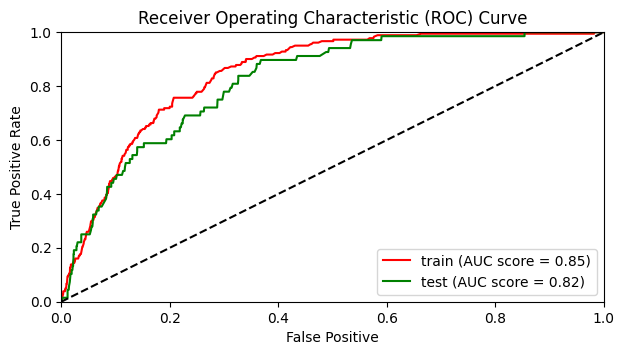

In [59]:
# creating a ROC curve
from sklearn import metrics

# Data for ROC curve train
fpr_train, tpr_train, threshold_train = \
metrics.roc_curve(train_scores.y_true, train_scores.y_prob)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Data for ROC curve test
fpr_test, tpr_test, threshold_test = \
metrics.roc_curve(test_scores.y_true, test_scores.y_prob)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# setting the figure size
plt.figure(figsize=(7, 3.5))

# creating the two plots
plt.plot(fpr_train, tpr_train, 'r', label = 'train (AUC score = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'g', label = 'test (AUC score = %0.2f)' % roc_auc_test)

# setting the title, legend, labels etc.
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1,],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive')

/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


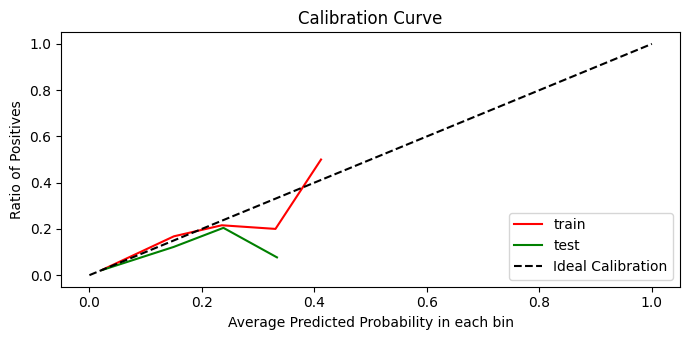

In [60]:
from sklearn.calibration import calibration_curve
# saving data for calibration plot using train data
xaxis_train, yaxis_train = calibration_curve(train_scores.y_true, train_scores.y_prob,
n_bins = 10, normalize = False,
strategy='uniform')

# saving data for calibration plot using test data
xaxis_test, yaxis_test = calibration_curve(test_scores.y_true, test_scores.y_prob,
n_bins = 10, normalize = False,
strategy='uniform')

# setting figure size
plt.figure(figsize=(7, 3.5))

# creating calibration plots
plt.plot(yaxis_train, xaxis_train, "r-",label="%s" % ('train', ))
plt.plot(yaxis_test, xaxis_test, "g-",label="%s" % ('test', ))

# setting title, legends, labels etc.
plt.title('Calibration Curve')
plt.ylabel ('Ratio of Positives')
plt.xlabel('Average Predicted Probability in each bin')
plt.plot([0, 1], [0, 1], "k--", label="Ideal Calibration")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


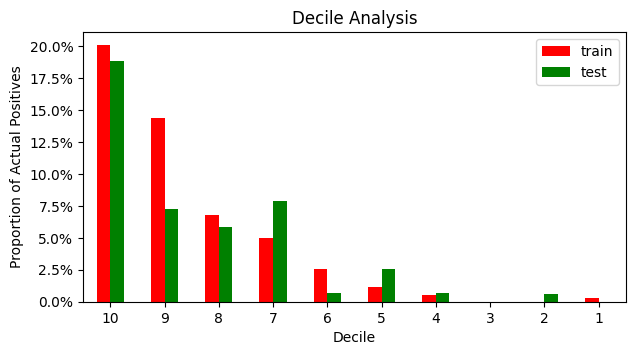

In [61]:
# saving data for decile plot using train data
cr_train, _ = calibration_curve(train_scores.y_true, train_scores.y_prob,
n_bins = 10, normalize = False,
strategy='quantile')

# saving data for decile plot using test data
cr_test, _ = calibration_curve(test_scores.y_true, test_scores.y_prob,
n_bins = 10, normalize = False,
strategy='quantile')

# creating dataframe to compare the decile data train vs. test
decile_comparison = pd.concat([pd.Series(np.flip(np.arange(1,11)),name='decile'),
pd.Series(cr_train, name='train'),
pd.Series(cr_test, name = 'test')],axis=1)

# sorting the data by decile
decile_comparison = decile_comparison.sort_values(by='decile')
decile_comparison = decile_comparison.reset_index(drop = True)

# making the decile lables to be 10 to 1
decile_comparison.decile = np.flip(np.arange(1,11))

# creating decile plot
decile_comparison.plot.bar(x='decile', stacked=False,
subplots=False, figsize=(7,3.5), color=['r','g'])

# setting title, lavbels etc.
plt.title('Decile Analysis')
plt.xlabel('Decile')
plt.ylabel('Proportion of Actual Positives')
plt.xticks(rotation='horizontal')
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

In [ ]:
#https://www.analytixlabs.co.in/blog/logistic-regression-in-python/#Stage_3_Model_Fitting